# Friday Something Flappy Bird AI

## Introduction

Flappy bird is a mobile game which became hugely popular in early 2014. In the game, the player controls a bird tasked with flying between gaps of green pipes. The bird continuously falls downwards, unless the player taps the screen, giving the bird a short burst of upwards speed. The goal of this project is to develop an artificial intellegence that can play Flappy Bird at a level comparable to or beyond a regular human player.

## Reinforcement Learning Task

Given that nature of the problem, reinforcement learning is the most appropriate learning paradigm. The task will be for the AI to, given some input, determine whether or not to "flap" at each frame. Every frame the bird does not crash into a pipe or the floor, the AI will be granted a reward of 1. This will encourage the AI to survive as long as possible.

## Exploratory Analysis of Reinforcement Learning Task

The task is resonably simple, the main decision to make is what input should be given for the AI. There are two options:
1. Take a screenshot of the game, and use a convolutional neural network to extract important features (player, obstacles)
1. Directly use player position and obstacle position as inputs

It was chosen to use the second option as it would make the model simpler, could train faster as there is no need to draw graphics, and likely converge in fewer iterations as the model does not need to first learn what features are important. Seven inputs where given to the model, these were:
- First pipe x coordinate
- First pipe y coordinate
- Second pipe x coordinate
- Second pipe y coordinate
- Player y coordinate
- Player y velocity
- Whether or not the player flapped on the previous frame
In the NEAT Model these seven inputs were adequate, but in the Q-Learning model these inputs of the previous three frames where also given, totalling 28 inputs.

## Models

Given that the task was a non-episodic reinforcement learning problem it was necessary to use models that could train under these conditions. Some of the options available included:
- Value Function Learning
    - TD-Learning
    - Q-Learning
        - Deep Q-Networks (DQN)
        - Double DQN
- Policy Learning
    - Evolutionary Strategies
        - Genetic Algorithm
        - NEAT
    - Policy Gradients
- Actor-Critic

NEAT and Q-Learning were chosen because of the precedent of these methods being used for similar tasks.

The flappy bird game, and graphics is credit of https://github.com/yenchenlin/DeepLearningFlappyBird.

Yen Chen Lin utlized a CNN to read the screen pixels to play flappy bird, we have utilised his game but adapted the outputs so our models could learn the game on a few basic parameters such as [player position, pipes position, player velocity].

In [1]:
# FLAPPY BIRD GRAPHICS FILES FROM https://github.com/yenchenlin/DeepLearningFlappyBird

import pygame
import sys
def load():
    # path of player with different states
    PLAYER_PATH = (
            'assets/sprites/redbird-upflap.png',
            'assets/sprites/redbird-midflap.png',
            'assets/sprites/redbird-downflap.png'
    )

    # path of background
    BACKGROUND_PATH = 'assets/sprites/background-black.png'

    # path of pipe
    PIPE_PATH = 'assets/sprites/pipe-green.png'

    IMAGES, SOUNDS, HITMASKS = {}, {}, {}

    # numbers sprites for score display
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    # base (ground) sprite
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    # sounds
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'

    SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
    SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
    SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
    SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
    SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

    # select random background sprites
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()

    # select random player sprites
    IMAGES['player'] = (
        pygame.image.load(PLAYER_PATH[0]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[2]).convert_alpha(),
    )

    # select random pipe sprites
    IMAGES['pipe'] = (
        pygame.transform.rotate(
            pygame.image.load(PIPE_PATH).convert_alpha(), 180),
        pygame.image.load(PIPE_PATH).convert_alpha(),
    )

    # hismask for pipes
    HITMASKS['pipe'] = (
        getHitmask(IMAGES['pipe'][0]),
        getHitmask(IMAGES['pipe'][1]),
    )

    # hitmask for player
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
        getHitmask(IMAGES['player'][2]),
    )

    return IMAGES, SOUNDS, HITMASKS

def getHitmask(image):
    """returns a hitmask using an image's alpha."""
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask


pygame 2.5.2 (SDL 2.28.3, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# FLAPPY BIRD CODE FROM https://github.com/yenchenlin/DeepLearningFlappyBird

import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

FPS = 30
SCREENWIDTH  = 288
SCREENHEIGHT = 512

pygame.init()
FPSCLOCK = pygame.time.Clock()
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
pygame.display.set_caption('Flappy Bird')

IMAGES, SOUNDS, HITMASKS = load()
PIPEGAPSIZE = 100 # gap between upper and lower part of pipe
BASEY = SCREENHEIGHT * 0.79

PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
BACKGROUND_WIDTH = IMAGES['background'].get_width()

PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])


class GameState:
    def __init__(self):
        self.score = self.playerIndex = self.loopIter = 0
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # player velocity, max velocity, downward accleration, accleration on flap
        self.pipeVelX = -4
        self.playerVelY    =  0    # player's velocity along Y, default same as playerFlapped
        self.playerMaxVelY =  10   # max vel along Y, max descend speed
        self.playerMinVelY =  -8   # min vel along Y, max ascend speed
        self.playerAccY    =   1   # players downward accleration
        self.playerFlapAcc =  -9   # players speed on flapping
        self.playerFlapped = False # True when player flaps

    def frame_step(self, flap):
        pygame.event.pump()

        reward = 0.1
        terminal = False

        if flap:
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
                #SOUNDS['wing'].play()

        # check for score
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                #SOUNDS['point'].play()
                reward = 1

        # playerIndex basex change
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # player's movement
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # move pipes to left
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # check if crash here
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        if isCrash:
            #SOUNDS['hit'].play()
            #SOUNDS['die'].play()
            terminal = True
            self.__init__()
            reward = -1

        # draw sprites
        SCREEN.blit(IMAGES['background'], (0,0))

        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        # print score so player overlaps the score
        # showScore(self.score)
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        return image_data, reward, terminal

def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

In [3]:
#flappy no graphics for DQL

import numpy as np
import sys
import random
import pygame
import game.flappy_bird_utils as flappy_bird_utils
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

FPS = 30
SCREENWIDTH  = 288
SCREENHEIGHT = 512

pygame.init()
FPSCLOCK = pygame.time.Clock()
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
pygame.display.set_caption('Flappy Bird')

IMAGES, SOUNDS, HITMASKS = flappy_bird_utils.load()
PIPEGAPSIZE = 100 # gap between upper and lower part of pipe
BASEY = SCREENHEIGHT * 0.79

PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
BACKGROUND_WIDTH = IMAGES['background'].get_width()

PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])


class GameNoGraphics:
    def __init__(self):
        self.score = self.playerIndex = self.loopIter = 0
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # player velocity, max velocity, downward accleration, accleration on flap
        self.pipeVelX = -4
        self.playerVelY    =  0    # player's velocity along Y, default same as playerFlapped
        self.playerMaxVelY =  10   # max vel along Y, max descend speed
        self.playerMinVelY =  -8   # min vel along Y, max ascend speed
        self.playerAccY    =   1   # players downward accleration
        self.playerFlapAcc =  -9   # players speed on flapping
        self.playerFlapped = False # True when player flaps

    def get_next_pipe_index(self):
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        distance = [0, 0]
        idx = 0
        for pipe in self.upperPipes:
            if (idx == 2):
                break
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos >= playerMidPos:
                distance[idx] = pipeMidPos - playerMidPos
            else:
                distance[idx] = 999
            idx += 1
        return distance.index(min(distance))


    def frame_step(self, flap):
        pygame.event.pump()

        reward = 0.4
        terminal = False

        if flap:
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
                #SOUNDS['wing'].play()

        next_pipe_idx = self.get_next_pipe_index()
        playerMidPos = self.playery + PLAYER_HEIGHT/2
        pipeUpperMidPos = self.upperPipes[next_pipe_idx]['y']
        pipeLowerMidPos = self.lowerPipes[next_pipe_idx]['y']
        # if playerMidPos < pipeUpperMidPos + 1 and playerMidPos > pipeLowerMidPos - 1:
        #     reward = 0.2
        # if playerMidPos > pipeLowerMidPos - 100 and playerMidPos < pipeLowerMidPos:
        #     # print("within")
        #     reward = 0.2
        if playerMidPos <= 0.2*SCREENHEIGHT:
            # print("too high")
            reward = -0.2
        if playerMidPos <= 0.1*SCREENHEIGHT:
            # print("too high")
            reward = -0.4


        # check for score
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                #SOUNDS['point'].play()
                reward = 10

        # playerIndex basex change
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # player's movement
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # move pipes to left
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # check if crash here
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        if isCrash:
            #SOUNDS['hit'].play()
            #SOUNDS['die'].play()
            terminal = True
            self.__init__()
            reward = -5

        # # draw sprites
        # SCREEN.blit(IMAGES['background'], (0,0))

        # for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
        #     SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
        #     SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        # SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        # # print score so player overlaps the score
        # # showScore(self.score)
        # SCREEN.blit(IMAGES['player'][self.playerIndex],
        #             (self.playerx, self.playery))

        # image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        # pygame.display.update()
        # FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        return 0, reward, terminal

def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False


In [4]:
# FLAPPY BIRD CODE WITH GRAPHICS REMOVED

import random
import pygame
from itertools import cycle

SCREENWIDTH  = 288
SCREENHEIGHT = 512

IMAGES, SOUNDS, HITMASKS = load()
PIPEGAPSIZE = 100 # gap between upper and lower part of pipe
BASEY = SCREENHEIGHT * 0.79

PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
BACKGROUND_WIDTH = IMAGES['background'].get_width()

PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])


class GameStateNoGraphics:
    def __init__(self):
        self.score = self.playerIndex = self.loopIter = 0
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # player velocity, max velocity, downward accleration, accleration on flap
        self.pipeVelX = -4
        self.playerVelY    =  0    # player's velocity along Y, default same as playerFlapped
        self.playerMaxVelY =  10   # max vel along Y, max descend speed
        self.playerMinVelY =  -8   # min vel along Y, max ascend speed
        self.playerAccY    =   1   # players downward accleration
        self.playerFlapAcc =  -9   # players speed on flapping
        self.playerFlapped = False # True when player flaps

    def frame_step(self, flap):
        if flap:
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True

        # playerIndex basex change
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # player's movement
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # move pipes to left
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # remove first pipe if it's out of the screen
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # check if crash here
        isCrash = checkCrash({'x': self.playerx, 'y': self.playery, 'index': self.playerIndex}, self.upperPipes, self.lowerPipes)
        if isCrash:
            self.__init__()

        return isCrash


def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False


In [5]:
# HELPER FUNCTION TO GET INPUT FROM FLAPPY BIRD GAME

import torch

def get_gamestate_info(game_state):
    """
    gets coordinates of the two pipes
    usage:          pipe_info = get_pipes_info(game_state)
                    pipe_info["pipe0"]["upper"]["x"] = x coordinate of the upper pipe of the first pipe
    @args:          game_state
    @returns:         
        "pipe0": {
            "upper": {
                "x":
                "y": 
            },
            "lower": {
                "x": 
                "y": 
            }
        },
        "pipe1": {
            "upper": {
                "x": ,
                "y": 
            },
            "lower": {
                "x": 
                "y": 
            }
        }, 
        "player": {
            "x": 
            "y": 
            "VelY":
            "AccY": 
            "Flapped": 
        }
    """
    return {
        "pipe0": {
            "upper": {
                "x": game_state.upperPipes[0]['x'],
                "y": game_state.upperPipes[0]['y']
            },
            "lower": {
                "x": game_state.lowerPipes[0]['x'],
                "y": game_state.lowerPipes[0]['y']
            }
        },
        "pipe1": {
            "upper": {
                "x": game_state.upperPipes[1]['x'],
                "y": game_state.upperPipes[1]['y']
            },
            "lower": {
                "x": game_state.lowerPipes[1]['x'],
                "y": game_state.lowerPipes[1]['y']
            }
        },
        "player": {
            "x": game_state.playerx,
            "y": game_state.playery,
            "VelY": game_state.playerVelY,
            "AccY": game_state.playerAccY,
            "Flapped": game_state.playerFlapped,
        }
    }

def get_input_layer(game_state):
    """
    gets gamestate but returns it as a tensor. Use when feeding into ML algorithm
    Arguments: game_state
    Returns: tensor of shape (6, 1) containing same information as get_gamestate_info, but without the dictionary.
    """
    return torch.tensor([game_state.lowerPipes[0]['x'], game_state.lowerPipes[0]['y'], 
                         game_state.lowerPipes[1]['x'], game_state.lowerPipes[1]['y'], 
                        game_state.playery, game_state.playerVelY, game_state.playerFlapped])


def get_input_layer_2(game_state):
    """
    gets gamestate but returns it as a np array. Use when feeding into ML algorithm
    Arguments: game_state
    Returns: tensor of shape (7, 1) containing same information as get_gamestate_info, but without the dictionary.
    """
    # print("pipe height: ", game_state.lowerPipes[0]['y'])
    return np.array([game_state.lowerPipes[0]['x'], game_state.lowerPipes[0]['y'], game_state.lowerPipes[0]['y'] - 100,
                         game_state.lowerPipes[1]['x'], game_state.lowerPipes[1]['y'], game_state.lowerPipes[0]['y'] - 100,
                        game_state.playery])

## NEAT Algorithm

The NeuroEvolution of Augmenting Topologies (NEAT) Algorithm is a variation of the Genetic Algorithm approach, developed by Kenneth O. Stanley and Risto Miikkulainen in 2002 [1]. Like the Genetic Algorithm, the general approach is to generate a population of random models. Each model is then given a fitness value, depending on how well it performs at a particular task. A new population is then made through a combination operator and a mutation operator. The combination operator takes two (or more) models and combines then, and the mutation operator takes a single model and changes it slightly. The models with higher fitness are more likely to be combined with other models for the next generation, which should increase the average fitness. 

The traditional Genetic Algorithm approach relies on a fixed model topology, such that only the weights of the model are modified. In contrast, the NEAT algorithm begins with a simplified model, such as input nodes connecting directly to output nodes, and evolves the topology of the models too. New neurons and connections are added to existing models through the mutation operator. To keep track of the evolving model topologies, each model is assigned a set of node genes and a set of connection genes. Each gene is given a unique innovation number. When combining models, only genes with the same innovation number are combined.
 
The NEAT algorithm also employs a technique called Speciation, where the population is grouped into species of similar topologies. Models are then more likely to be combined with other models of the same species. This helps maintain diversity in the population and prevents early convergence to a suboptimal solution. 

A 2006 study by Taylor, Whiteson and Stone [2] compared the NEAT algorithm to a temporal difference method SARSA. The study found that NEAT could find a better policy than SARSA, although it required more iterations to do so. The study also found that SARSA performed better when the domain was fully observable and NEAT converged quicker with a deterministic fitness function. Overall NEAT is shown to be a highly competitive algorithm for reinforcement learning.


In [6]:
# NEAT MODEL

import os.path
import pickle
import neat

class NEATModel:
    def __init__(self):
        configFile = os.path.join(os.path.abspath(''), 'NEATConfig')

        self.config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                                  neat.DefaultSpeciesSet, neat.DefaultStagnation,
                                  configFile)

        self.population = neat.Population(self.config)

        self.population.add_reporter(neat.StdOutReporter(True))
        stats = neat.StatisticsReporter()
        self.population.add_reporter(stats)
        self.population.add_reporter(neat.Checkpointer(20))
        self.bestGenome = None
        self.gameState = None

    def run(self, generations, checkpointFileName=""):
        if checkpointFileName != "":
            self.population = neat.Checkpointer.restore_checkpoint(checkpointFileName)
        self.bestGenome = self.population.run(self.evaluateGenomes, generations)
        with open("NEATBestGenome.pkl", "wb") as f:
            pickle.dump(self.bestGenome, f)
            f.close()

    def loadBest(self):
        with open("NEATBestGenome.pkl", "rb") as f:
            self.bestGenome = pickle.load(f)

    def playGame(self):
        self.gameState = GameState()
        network = neat.nn.FeedForwardNetwork.create(self.bestGenome, self.config)
        go = True
        while go:
            networkInput = get_input_layer(self.gameState)
            networkOutput = network.activate(networkInput)[0]
            flap = networkOutput > 0.5  # sigmoid activation, output should be between 0 and 1
            _, _, terminal = self.gameState.frame_step(flap)
            if terminal:
                go = False

    def testBest(self, runs):
        self.gameState = GameStateNoGraphics()
        network = neat.nn.FeedForwardNetwork.create(self.bestGenome, self.config)
        fitnesses = []
        for i in range(runs):
            thisRunFitness = 0
            go = True
            while go:
                thisRunFitness += 1
                networkInput = get_input_layer(self.gameState)
                networkOutput = network.activate(networkInput)[0]
                flap = networkOutput > 0.5  # sigmoid activation, output should be between 0 and 1
                if self.gameState.frame_step(flap) or thisRunFitness > 10000:
                    go = False
                    fitnesses.append(thisRunFitness)
                    if (i+1) % 100 == 0:
                        print("Finished run: " + str(i+1) + "/" + str(runs))
        print(fitnesses)

    @staticmethod
    def evaluateGenomes(genomes, config):
        gameState = GameStateNoGraphics()
        for genome_id, genome in genomes:
            network = neat.nn.FeedForwardNetwork.create(genome, config)
            runs = 10
            averageFitness = 0
            for i in range(runs):
                thisRunFitness = 0
                go = True
                while go:
                    thisRunFitness += 1
                    networkInput = get_input_layer(gameState)
                    networkOutput = network.activate(networkInput)[0]
                    flap = networkOutput > 0.5  # sigmoid activation, output should be between 0 and 1
                    if gameState.frame_step(flap) or thisRunFitness > 10000:
                        go = False
                        averageFitness += thisRunFitness / runs
            genome.fitness = averageFitness


ModuleNotFoundError: No module named 'neat'

In [6]:
# TRAINING AND TESTING THE NEAT MODEL

neatModel = NEATModel()
# neatModel.run(300)  # Train the model, will take quite a long time!
neatModel.loadBest()  # Load the best model from training
neatModel.playGame()  # Watch the best model play the game (look at your taskbar it won't popup automatically)
neatModel.testBest(1000)  # Test performance of the best model

Finished run: 100/1000
Finished run: 200/1000


KeyboardInterrupt: 

## Results

### NEAT Algorithm

The training terminated after about 120 generations. Given that each generation had 150 models, the total number of models generated was 18000. The best model was run 1000 times to get a more accurate assessment of its performance. The mean fitness was 479, the median fitness was 234, and the standard deviation was 546. The graph below shows a histogram of the fitness of the 1000 runs.
![Histogram of testing best NEAT Model](NEATHistogram.png)
Noticeably 259 (~26%) of runs had a fitness of 86, which occurs when the model fails to get past the first pipe. The best run had a fitness of 3823. At 30 frames per second, this is equivalent to surviving for about 127 seconds.

## Discussion

### NEAT Algorithm

The NEAT Algorithm resulted in a model that performed reasonably well, although with quite a large variance. With a median fitness of 234, this is equivalent to surviving for 7.8 seconds, which is similar to the performance of an average human player. Further training would likely improve the model further, but more care should be taken to avoid outlier runs from overestimating the performance of the model. This could be done by taking the median of a number of runs rather than the mean. Increasing the number of runs each model is tested on would also help reduce inaccuracy in performance evaluation, but this comes with an increase in training time. One approach could be to start with only a single run, and increase the number of runs with subsequent generations. This would help prevent multiple runs being wasted on early models that consistently perform poorly.

## References

[1] Kenneth O. Stanley and Risto Miikkulainen, Efficient Evolution of Neural Network Topologies, 2002, The University of Texas<br>
[2] Matthew E. Taylor, Shimon Whiteson, and Peter Stone, Comparing Evolutionary and Temporal Difference Methods in a Reinforcement Learning Domain, 2006, Proceedings of the Genetic and Evolutionary Computation Conference.

Deep Q-Learning

Q-learning is one of the most popular methods of doing reinforcement learning. It operates by estimating the value of a state action pair Q(s,a) and updates this value in accordance to the reward it receives for its actions. Traditional Q-learning uses a "lookup table" which stores the estimated value of a state action pair. However, this method has its flaws. Firstly, all possible values must be populated on the lookup table, and if the task is complex this means that the lookup table is impractically large and immensely difficult to populate fully. Additionally, traditional tables also have difficulty handling high-dimentional state spaces, which hinders its ability to interpret complex tasks such as flapping a bird.

Using a Neural Network as an estimator for the Q value solves both of these problems. Accordingly many famous papers such as "Playing Atari with Deep Reinforcement Learning" by Volodymyr Mnih, et. al used deep Q learning to solve tasks similar to flappy bird.

In [13]:
# define the neural net of the agent
import numpy as np
import random
import torch
import torch.optim as optim
# from utils import get_input_layer_2 as input
# import game.flappyNoGraphics as Game
# import game.wrapped_flappy_bird as GameVisual
from collections import deque
import pickle





import torch
import torch.nn as nn
import torch.optim as optim

class Network(nn.Module):
    def __init__(self, lr):
        super(Network, self).__init__()

        self.n_actions = 2
        self.hid_1 = 128
        self.hid_2 = 128
        self.hid_3 = 128
        self.inputs = 7 * 4
        self.model = nn.Sequential(
            nn.Linear(self.inputs, self.hid_1),
            nn.ReLU(),
            nn.Linear(self.hid_1, self.hid_2),
            nn.ReLU(),
            nn.Linear(self.hid_2, self.hid_3),
            nn.ReLU(),
            nn.Linear(self.hid_3, self.n_actions),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.SmoothL1Loss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        output = self.model(x.type(torch.FloatTensor).to(self.device))
        return output

In [14]:
# create a class to manage the state. Each state is a stack of 4 "frame" of the game
# which provides the agent on information of the bird's movement.

from collections import deque
import torch
# from utils import get_input_layer_2 as input
import numpy as np

class StateManager(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        starting_state = [0, 0, 0, 0, 0, 0, 0]
        for _ in range(capacity):
            self.memory.append(starting_state)

    def push(self, game):
        """Save a frame, 
            returns tensor of flattened state frames
        """
        state_frame = get_input_layer_2(game)
        self.memory.popleft()
        self.memory.append(state_frame)
        tensor_list = []
        for i in range(4):
            tensor_list.append(self.memory[i])
        return np.array(tensor_list).flatten()
    
    def get(self):
        # return np array of state frames
        tensor_list = []
        for i in range(4):
            tensor_list.append(self.memory[i])
        return np.array(tensor_list).flatten()

In [19]:
# create the class for the agent.

class Agent(object):
    def __init__(self):
        """
        Porperties:
            gamma (float): Future reward discount rate.
            epsilon (float): Probability for choosing random policy.
            epsilon_decay (float): Rate at which epsilon decays toward zero.
            learning_rate (float): Learning rate for Adam optimizer.

        Returns:
            Agent
        """
        # constant parameters
        self.gamma = 0.95
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.996
        self.lr = 0.00005
        self.batch_size = 64
        self.max_mem_size = 10000
        # self.input_dims = 7 * 4

        #variable parameters
        self.epsilon = 0.01
        self.mem_cntr = 0
        self.mem_cntr_successful = 0

        # initializing memory
        self.memory = deque(maxlen=self.max_mem_size)
        self.memory_successful = deque(maxlen=1000)
        self.episodic_memory = []

        #initialize networks
        self.network = Network(self.lr)

    def save_self(self):
        with open('model.pickle', 'wb') as handle:
            pickle.dump(self, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def save_experience(self):
        with open('experience.pickle', 'wb') as handle:
            pickle.dump(self.memory, handle)
        with open('experience_successful.pickle', 'wb') as handle:
            pickle.dump(self.memory_successful, handle)

    def load_experience(self):
        with open('experience.pickle', 'rb') as handle:
            self.memory = pickle.load(handle)
        with open('experience_successful.pickle', 'rb') as handle:
            self.memory_successful = pickle.load(handle)

    def getMemory(self):
        return self.memory

    def nextEpisode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def getepsilon(self):
        return self.epsilon

    def remember(self, state, action, reward, next_state, game_over, score, next_reward):
        if (self.mem_cntr >= self.max_mem_size - 2):
            for i in range(self.max_mem_size - 3000):
                self.memory.popleft()
            self.mem_cntr = len(self.memory) - 1

        memory = [state, action, reward, next_state, game_over, score, next_reward]
        self.memory.append(memory)

        self.mem_cntr += 1

    def remember_successful(self, state, action, reward, next_state, game_over, score, next_reward):
        if (self.mem_cntr_successful >= 1000 - 20):
            for i in range(1000 - 500):
                self.memory_successful.popleft()
            self.mem_cntr_successful = len(self.memory_successful) - 1

        memory = [state, action, reward, next_state, game_over, score, next_reward]
        self.memory_successful.append(memory)

        self.mem_cntr_successful += 1

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            # exploration

            # 2 in 30 = averages about 1 press every 0.5 seconds which is in the ballpark of whats required to play the game. 
            # Gives bot best start possible (as it actually has a chance of making it through the first block!)
            # in flappy bird a flap changes the gamestate a lot more than a no-flap.
            determiner = np.random.randint(0, 30);
            if (determiner <= 2):
                return 1
            return 0
        else:
            # exploitation, select epsilon-greedy action.
                state_tensor = torch.tensor([state]).to(self.network.device, dtype=torch.int32)
                action = torch.argmax(self.network.forward(state_tensor)).item()
                
        return action
    
    def updateEpsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def learn(self):
        """
        learn from a random batch of experiences
        """
        if self.mem_cntr < self.batch_size:
            return
        
        self.network.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.max_mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # memory = [state, action, reward, next_state, game_over, score, next_reward]
        state_batch = torch.tensor([self.memory[i][0] for i in batch]).to(self.network.device, dtype=torch.float32)
        action_batch = torch.tensor([self.memory[i][1] for i in batch])
        reward_batch = torch.tensor([self.memory[i][2] for i in batch]).to(self.network.device, dtype=torch.float32)
        new_state_batch = torch.tensor([self.memory[i][3] for i in batch]).to(self.network.device, dtype=torch.float32)
        game_over_batch = torch.tensor([self.memory[i][4] for i in batch]).to(self.network.device, dtype=torch.bool)

        #estimate q(s,a) and q(s',a').
        q_current = self.network.forward(state_batch)[batch_index, action_batch]
        q_next = self.network.forward(new_state_batch)
        q_next[game_over_batch] = 0.0
        # q(st,at) = r + gamma * max(q(s',a')
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

        # smoothl1 loss and back-propagation
        loss = self.network.loss(q_target, q_current).to(self.network.device)
        loss.backward()
        #prevent exploding gradient
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.network.optimizer.step()

    def learn_successful(self):
        """
        learn from the set of experience that the agent was successful in. 
        Incentivises the agent to 
        """
        if self.mem_cntr_successful < self.batch_size:
            return
        
        # print("learning successful")
        self.network.optimizer.zero_grad()
        max_mem = min(self.mem_cntr_successful, self.max_mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # memory = [state, action, reward, next_state, game_over, score]
        state_batch = torch.tensor([self.memory[i][0] for i in batch]).to(self.network.device, dtype=torch.float32)
        action_batch = torch.tensor([self.memory[i][1] for i in batch])
        reward_batch = torch.tensor([self.memory[i][2] for i in batch]).to(self.network.device, dtype=torch.float32)
        new_state_batch = torch.tensor([self.memory[i][3] for i in batch]).to(self.network.device, dtype=torch.float32)
        game_over_batch = torch.tensor([self.memory[i][4] for i in batch]).to(self.network.device, dtype=torch.bool)
        #estimate q(s,a) and q(s',a').
        q_current = self.network.forward(state_batch)[batch_index, action_batch]
        q_next = self.network.forward(new_state_batch)
        q_next[game_over_batch] = 0.0
        # q(st,at) = r + gamma * max(q(s',a')
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
        
        # smoothl1 loss and back-propagation
        loss = self.network.loss(q_target, q_current).to(self.network.device)
        loss.backward()
        self.network.optimizer.step()

    def update_episodic_memory(self, state, action, reward, next_state, done, score, current_step):
        """appends to a temporary memory. The temporary memory is uploaded to the main memory
        once a game is complete.
        """
        self.episodic_memory.append([state, action, reward, next_state, done, score, 0])


In [ ]:
def load_self():
    with open('model.pickle', 'rb') as handle:
        agent = pickle.load(handle)
        return agent

In [20]:
#the trainer allows a human to play the game then upload the relevant data to the agent.
# increases the rate at which the agent initially learns.
import keyboard
import pickle

class Trainer(object):
    def __init__(self, agent):
        self.runs = 10
        self.agent = agent
        self.game = GameState()
        self.state_manager = StateManager(4)

    def play(self, runs=10):
        self.runs = runs
        self.agent.episodic_memory = []
        current_step = 0
        # for runs amount of games
        for i in range(self.runs):
            #initialize game
            self.game = GameState()
            self.state_manager = StateManager(4)
            state = self.state_manager.get()
            done = False
            score = 0
            # manually play the game
            while not done:
                if keyboard.is_pressed(" "):
                    action = 1
                    _, reward, _ = self.game.frame_step(True)
                else:
                    action = 0
                    _, reward, _ = self.game.frame_step(False)
                if (reward == -5):
                    done = True
                    final_score = score
                    reward = -5
                score += reward

                self.state_manager.push(self.game)
                
                #upload experience and train the agent on the human gameplay
                next_state = self.state_manager.get()
                self.agent.update_episodic_memory(state, action, reward, next_state, done, score, current_step)
                self.agent.learn()
                self.agent.learn_successful()
                current_step += 1
                state = next_state
            for frame in self.agent.episodic_memory:
                self.agent.remember(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
                self.agent.remember_successful(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])

In [24]:
#main training loop
import matplotlib.pyplot as plt


def train(agent):

    
    scores, median_scores, eps_history, time_history, time_median = [], [], [], [], []
    n_games = 100000
    success_threshold = 15
    trainer = Trainer(agent)

    # trainer.play(10)
    # agent.save_experience()
    agent.load_experience()
    #learn from human experiences for a headstart
    #without this, the agent typically just default to a policy of only flapping or only doing nothing
    for i in range(100):
        agent.learn()
    high_score = 40
    # for n_games amount of games
    for i in range(n_games):
        #initialize game
        game = GameNoGraphics()
        if (keyboard.is_pressed("p")):
            game = GameState()
        score = 0
        game_over = False
        state_manager = StateManager(4)
        state = state_manager.get()
        done = False
        # state, action, reward, next_state, done, score
        agent.episodic_memory = []
        current_step = 0
        #while the game is not complete
        while not done:
            #select an action
            action = agent.select_action(state)
            _, reward, _ = game.frame_step(action)
            #calculate the state
            state_manager.push(game)
            next_state = state_manager.get()
            if (reward == -5):
                done = True
                final_score = score
                reward = -5
            score += reward
            #remember the action taken
            # agent.remember(state, action, reward, next_state, done, score)
            agent.update_episodic_memory(state, action, reward, next_state, done, score, current_step)
            

            state = next_state
            current_step += 1
        #after each game, learn a random batch of experiences from memory
        #and also lean a batch of experiences that the bird was successful in.
        agent.learn()
        agent.learn_successful()
        if (score > high_score):
            high_score = score
            agent.save_self()
        agent.updateEpsilon()
        #upload memory to main memory
        eps_history.append(agent.epsilon)
        for frame in agent.episodic_memory:
            agent.remember(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # success_threshold is typically 10 greater than the median score.
        if (score > success_threshold):
            agent.remember_successful(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # agent.remember(state, action, reward, next_state, done, score)

        #calculate some statistics for evaluation
        median_score = np.median(scores[-100:])
        success_threshold = max(success_threshold, median_score + 10)
        scores.append(score)
        median_scores.append(median_score)
        time_history.append(current_step/30)
        median_t = np.median(time_history[-100:])
        time_median.append(median_t)
        if ((i % 100) == 0):
            print('episode: ', i,'score: %.2f' % score,
                    ' median score %.2f' % median_score, 'time %.2f' % (current_step/30),'median time %.2f' % (median_t) ,'epsilon %.2f' % agent.epsilon)
        if (keyboard.is_pressed("`")):
            break
    #save the final model
    torch.save(agent.network.state_dict(), 'Models/DQL/dqlmodel.pth')
    #plot.
    plt.plot(time_median)
    plt.show()

In [30]:
# def test(agent):
    #main training loop
import matplotlib.pyplot as plt


def test():

    
    scores, median_scores, eps_history, time_history, time_median = [], [], [], [], []
    n_games = 1000
    success_threshold = 15
    


    with open('model.pickle', 'rb') as handle:
        agent = pickle.load(handle)

    high_score = 40
    agent.epsilon = 0
    # for n_games amount of games
    for i in range(n_games):
        #initialize game
        game = GameState()
        score = 0
        game_over = False
        state_manager = StateManager(4)
        state = state_manager.get()
        done = False
        # state, action, reward, next_state, done, score
        current_step = 0
        #while the game is not complete
        while not done:
            #select an action
            action = agent.select_action(state)
            _, reward, _ = game.frame_step(action)
            #calculate the state
            state_manager.push(game)
            next_state = state_manager.get()
            if (reward == -5):
                done = True
                final_score = score
                reward = -5
            score += reward
            #remember the action taken
            # agent.remember(state, action, reward, next_state, done, score)
            # agent.update_episodic_memory(state, action, reward, next_state, done, score, current_step)
            

            state = next_state
            current_step += 1
        #after each game, learn a random batch of experiences from memory
        #and also lean a batch of experiences that the bird was successful in.
        # agent.learn()
        # agent.learn_successful()
        # if (score > high_score):
        #     high_score = score
        #     agent.save_self()
        # agent.updateEpsilon()
        #upload memory to main memory
        eps_history.append(agent.epsilon)
        # for frame in agent.episodic_memory:
        #     agent.remember(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # # success_threshold is typically 10 greater than the median score.
        # if (score > success_threshold):
        #     agent.remember_successful(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # agent.remember(state, action, reward, next_state, done, score)

        #calculate some statistics for evaluation
        median_score = np.median(scores[-100:])
        success_threshold = max(success_threshold, median_score + 10)
        scores.append(score)
        median_scores.append(median_score)
        time_history.append(current_step/30)
        median_t = np.median(time_history[-100:])
        time_median.append(median_t)
        if ((i % 100) == 0):
            print('episode: ', i,'score: %.2f' % score,
                    ' median score %.2f' % median_score, 'time %.2f' % (current_step/30),'median time %.2f' % (median_t) ,'epsilon %.2f' % agent.epsilon)
        if (keyboard.is_pressed("`")):
            break
    #save the final model
    torch.save(agent.network.state_dict(), 'Models/DQL/dqlmodel.pth')
    #plot.
    plt.plot(time_median)
    # plt.show()
    return time_history

In [31]:
time_history = test()

KeyboardInterrupt: 

In [29]:
print(time_history)

[6.766666666666667, 14.133333333333333, 5.6, 4.266666666666667, 3.533333333333333, 32.7, 29.366666666666667, 8.033333333333333, 9.6, 3.033333333333333, 5.4, 3.466666666666667, 6.666666666666667, 8.233333333333333, 5.3, 5.533333333333333, 6.733333333333333, 5.566666666666666, 16.433333333333334, 22.566666666666666, 37.7, 4.366666666666666, 8.1, 25.033333333333335, 14.066666666666666, 2.9, 8.133333333333333, 5.9, 31.433333333333334, 15.333333333333334, 27.6, 2.8666666666666667, 8.066666666666666, 37.36666666666667, 8.266666666666667, 9.133333333333333, 4.2, 13.0, 12.733333333333333, 2.9, 7.966666666666667, 17.866666666666667, 3.3333333333333335, 20.6, 8.0, 8.333333333333334, 8.033333333333333, 5.8, 5.466666666666667, 10.466666666666667, 4.666666666666667, 2.933333333333333, 13.266666666666667, 2.8666666666666667, 17.966666666666665, 9.166666666666666, 25.2, 9.666666666666666, 11.6, 4.333333333333333, 5.433333333333334, 14.333333333333334, 28.1, 11.566666666666666, 8.033333333333333, 20.1

episode:  0 score: -9.00  median score nan time 1.67 median time 1.67 epsilon 0.01
episode:  100 score: 15.00  median score 18.80 time 1.70 median time 2.02 epsilon 0.01
episode:  200 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  300 score: 31.00  median score 15.40 time 2.23 median time 1.80 epsilon 0.01
episode:  400 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  500 score: 14.60  median score 18.60 time 1.67 median time 2.00 epsilon 0.01
episode:  600 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  700 score: 63.40  median score 17.60 time 4.13 median time 1.95 epsilon 0.01
episode:  800 score: 63.80  median score 14.60 time 4.17 median time 1.67 epsilon 0.01
episode:  900 score: 19.00  median score 14.60 time 2.03 median time 1.67 epsilon 0.01
episode:  1000 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  1100 score: 14.60  median score 14.6

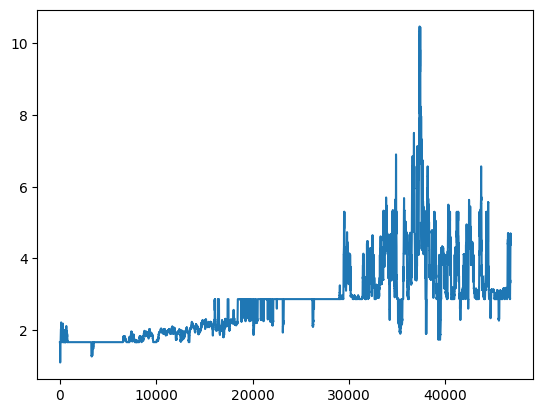

In [25]:
#run the DQL model training.
agent = Agent()
train(agent)


Results

The DQL agent was able to learn how to play flappy bird up to the level of a below-average human within 50 000 games. It had periods of outlying success (passing 10 pipes or more) but generally the DQL model could only consistently pass 2 - 3 pipes when trained adequately. (20 - 80k games). Overally learning progress was slow but steady, however the model would often get stuck in local min/maxes for thousands of games (for example flapping into the ceiling and eventually dying yield better results than flopping to the ground, but is in no way a good result!)

A good explanation of why it is so attracted to local maximas is due to the nature of exploration in the game and the way the game is structured. Flappy bird is a game where there are only two actions - one of which doesn't affect the game a lot (not flapping) and the other is extremely disruptive to the progress of the game (flapping). Additionally, the pipes are directly vertical which means that there is no difference in reward between a near miss and a far miss, making local maximas hard to escape and random movements often ineffective.

To combat this, the team implemented behaviour cloning. It allowed a human to play a few games, before having the model train on the human's actions. This was an extremely successful method as it gave the model "experiences" which inform it that the local maxima is not the global maxima. In addition, the local maxima problem was so severe that the authors had to create a negative reward zone near the ceiling of the game to disincentivise that behaviour.

Discussion

Overall, DQL proved its reliability in succeeding (eventually) in solving problems. However, its reliance on the reward system means that in games such as flappy bird where successful exploration by random action is very difficult and rare means that effectively it creates its own "dissapearing gradient" problem. It would achieve a successful run - only for it to be drowned out by thousands of unsuccessful runs to local maximas which in turn doesn't teach the model on how to make a successful run, generating thousands more of unsuccessful runs to drown out successful ones and continuing the loop. Accordingly, the authors implemented a "priority replay" system where runs that were considered better than normal was more heavily studied and trained on by the agent - overcoming the vicious local maxima loop.

Comparison vs NEAT

